In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import EngFormatter
from struct import unpack
import os, serial
from time import *
from scipy.optimize import curve_fit
from tqdm.notebook import trange

from threading import Thread

import ipywidgets as wdg

from serial.tools.list_ports import comports
seriais = ([p.device for p in comports()])

import pyvisa
rm = pyvisa.ResourceManager()
#print (rm)
device = rm.list_resources()

ports = list(device)+seriais
ports

['USB0::0x0699::0x0368::C044865::INSTR',
 'ASRL1::INSTR',
 'ASRL3::INSTR',
 'ASRL6::INSTR',
 'ASRL10::INSTR',
 'COM3',
 'COM1',
 'COM6']

In [2]:
def acquire(channel, port) -> 'takes the wave on the screen':
    '''Reads and downloads current data from the oscilloscope screen'''
    try:
        scope = rm.open_resource(port)
        scope.write("DATA:SOURCE " + channel)
        scope.write('DATA:WIDTH 2')
        scope.write('DATA:ENC SRI')
        ymult = float(scope.query('WFMPRE:YMULT?'))
        yzero = float(scope.query('WFMPRE:YZERO?'))
        yoff = float(scope.query('WFMPRE:YOFF?'))
        xincr = float(scope.query('WFMPRE:XINCR?'))
        xdelay = float(scope.query('HORizontal:POSition?'))
        scope.write('CURVE?')
        data = scope.read_raw()
        headerlen = 2 + int(data[1])
        header = data[:headerlen]
        ADC_wave = data[headerlen:-1]
        ADC_wave = np.frombuffer(ADC_wave, dtype=np.int16)
        Volts = (ADC_wave - yoff) * ymult  + yzero
        Time = np.arange(0, (xincr * len(Volts)), xincr)-((xincr * len(Volts))/2-xdelay)
        return Time, Volts
    except IndexError:
        return 0,0

In [3]:
tds = rm.open_resource(ports[0])

In [4]:
tds.query("*IDN?")

'TEKTRONIX,TBS 1052B,C044865,CF:91.1CT FV:v4.06\n'

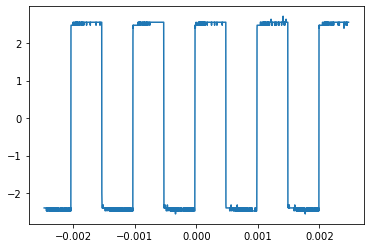

In [7]:
teste = acquire('CH1', ports[0])
plt.plot(teste[0],teste[1])

In [8]:
ACQ = { 
    'ACQuire' : ['ACQuire?', 'ACQuire:'],
    'types' : ['MODe', 'NUMACq', 'NUMAVg', 'STATE', 'STOPAfter'],
    'MODe': ['MODe?', 'SAMple', 'PEAKdetect', 'AVErage'],
    'NUMACq' : ['NUMACq?'],
    'NUMAVg' : ['NUMAVg?', '4', '16', '64', '128'], 
    'STATE' : ['STATE?', 'OFF', 'ON', 'RUN', 'STOP'],
    'STOPAfter' : ['STOPAfter?', 'RUNSTop', 'SEQuence']
}

ALLE = {
    'ALLEv': ['ALLEv?']
}

AUTOR = {
    'AUTORANGE' : ['AUTORANGE?', 'AUTORange:'],
    'types' : ['STATE', 'SETTings'],
    'STATE' : ['STATE?', 'OFF', 'ON'], 
    'SETTings' : ['SETTings?', 'HORizontal', 'VERTical', 'BOTH']
}

AUTOS = {
    'AUTOSet' : ['AUTOSet EXECute', 'AUTOSet:'], 
    'types' : ['ENABLE', 'SIGNAL', 'VIEW'],
    'ENABLE' : ['ENABLE'],
    'SIGNAL' : ['SIGNAL?'], 
    'VIEW' : ['MULTICYcle', 'SINGLECYcle', 'FFT', 'RISINGedge', 
              'FALLINGedge', 'FIELD', 'ODD', 'EVEN', 'LINE', 'LINENum', 'DCLIne', 
              'DEFault', 'NONE']
}

MEASU = {
    'MEASUrement' : ['MEASUrement?', 'MEASUrement:'], 
    'types' : ['IMMed', 'MEAS'],
    'IMMed' : ['TYPe']
}

MEASU_IMM = {'SOUrce' : ['CH1', 'CH2', 'MATH'],
             'TYPe' : ['CRMs', 'FALL', 'FREQuency', 'MAXImum', 
                       'MEAN', 'MINImum', 'NONe', 'NWIdth', 'PERIod',
                       'PK2pk', 'PWIdth','RISe', 'RMS', 'CURSORRms', 
                       'PDUTy', 'PHAse', 'DELAYRR', 'DELAYRF','DELAYFR', 
                       'DELAYFF', 'AMplitude', 'CMEAN', 'High', 'LOW', 
                       'NDUty','POVERshoot', 'NOVERshoot', 'CURSORMean', 
                       'BURSTWIDth' , 'AREA','CAREA', 'PPULSECount', 
                       'NPULSECount', 'REDGECount', 'FEDGECount']
            }

BUSY = {'BUSY' : ['BUSY?']}

CAL = {'CALibrate' : ['*CAL?', 'CALibrate:'], 
       'types' : ['ABOrt', 'CONTINUE', 'FACtory', 'INTERNAL', 'STATUS'],
       'ABOrt' : ['ABOrt'],
       'CONTINUE' : ['CONTINUE'],
       'FACtory' : ['FACtory'],
       'INTERNAL' : ['INTERNAL'],
       'STATUS' : ['STATUS?']
      }

CH = {'CH' :['CH1?', 'CH2?', 'CH1:', 'CH2:'], 
      'types' : ['BANdwidth', 'COUPling', 'CURRENTPRObe', 'INVert', 'POSition', 'PRObe', 'SCAle', 'VOLts', 'YUNit'],
      'BANdwidth' : ['BANdwidth?', 'ON', 'OFF'],
      'COUPling' : ['COUPling?', 'AC', 'DC', 'GND'],
      'CURRENTPRObe' : ['CURRENTPRObe?', '0.2', '1', '2', '5', '10', '50', '100', '1000'],
      'INVert' : ['INVert?', 'ON', 'OFF'],
      'POSition' : [],
      'PRObe' : ['PRObe?', '1', '10', '20', '50', '100', '500', '1000'],
      'SCAle' : [],
      'VOLts' : [],
      'YUNit' : []
     }

types = MEASU_IMM['TYPe']

Acquisition = [ACQ]
Status_and_Error = [ALLE, BUSY]
Miscellaneous = [AUTOR, AUTOS]
Measurement = [MEASU, MEASU_IMM]
Calibration_and_Diagnostic = [CAL]
Vertical = [CH]

def asktds(ch, types):
    tds.write("MEASUrement:IMMED:SOUrce " + ch)
    tds.write("MEASUrement:IMMED:TYPE " + types)
    return tds.query("MEASUrement:IMMED:VALUe?").strip('\n')

In [9]:
list(MEASU.keys())

['MEASUrement', 'types', 'IMMed']

In [236]:
list(MEASU.values())[0][1]+list(MEASU.keys())[2]

'MEASUrement:IMMed'

In [234]:
Measurement[1].items()

dict_items([('SOUrce', ['CH1', 'CH2', 'MATH']), ('TYPe', ['CRMs', 'FALL', 'FREQuency', 'MAXImum', 'MEAN', 'MINImum', 'NONe', 'NWIdth', 'PERIod', 'PK2pk', 'PWIdth', 'RISe', 'RMS', 'CURSORRms', 'PDUTy', 'PHAse', 'DELAYRR', 'DELAYRF', 'DELAYFR', 'DELAYFF', 'AMplitude', 'CMEAN', 'High', 'LOW', 'NDUty', 'POVERshoot', 'NOVERshoot', 'CURSORMean', 'BURSTWIDth', 'AREA', 'CAREA', 'PPULSECount', 'NPULSECount', 'REDGECount', 'FEDGECount'])])

In [233]:
ACQ[list(ACQ.keys())[0]][0]

'ACQuire?'

In [4]:
tds.query("*IDN?")

'TEKTRONIX,TBS 1052B,C044865,CF:91.1CT FV:v4.06\n'

In [7]:
types[9]

'PK2pk'

In [8]:
asktds('CH1', types[9])

'5.759999752E0'

In [14]:
for i in range(len(types)):
    print(i, types[i], asktds('CH1', types[i]), asktds('CH2', types[i]))

0 CRMs 1.7816183567E0 1.7688142061E0
1 FALL 2.78E-3 2.8199998E-3
2 FREQuency 1.0E2 1.0E2
3 MAXImum 2.5599999428E0 2.5599999428E0
4 MEAN -1.78791508E-2 -7.6830732E-3
5 MINImum -2.5599999428E0 -2.4800000191E0
6 NONe -2.5599999428E0 -2.4800000191E0
7 NWIdth 4.9999999E-3 5.02E-3
8 PERIod 9.9999998E-3 9.9999998E-3
9 PK2pk 5.1199998856E0 5.0399999619E0
10 PWIdth 4.9399999E-3 4.9799997E-3
11 RISe 2.7999999E-3 2.7999999E-3
12 RMS 1.7821164131E0 1.7672729492E0
13 CURSORRms 1.7803651094E0 1.7673316002E0
14 PDUTy 4.96000022888E1 4.96993980408E1
15 PHAse 1.439999938E0 0.0E0
16 DELAYRR 2.0E-5 0.0E0
17 DELAYRF -4.9299998E-3 -4.9799997E-3
18 DELAYFR 4.9999999E-3 4.9399999E-3
19 DELAYFF 0.0E0 0.0E0
20 AMplitude 4.9600000381E0 4.9600000381E0
21 CMEAN -1.64799988E-2 -7.9840319E-3
22 High 2.4800000191E0 2.4800000191E0
23 LOW -2.4800000191E0 -2.4800000191E0
24 NDUty 5.05999984741E1 5.03999977112E1
25 POVERshoot 1.6129016876E0 1.6129016876E0
26 NOVERshoot 1.6129016876E0 0.0E0
27 CURSORMean -1.92959998E-2 -

In [52]:
tds.write('AUTOSet EXECute')

(17, <StatusCode.success: 0>)

In [11]:
tds.write('AUTORANGE:SETTINGS BOTH ')
tds.write('AUTORANGE:STATE ON')

(20, <StatusCode.success: 0>)

In [60]:
tds.query("AUTORANGE:STATE?")

'0\n'